# Navigation with Deep Q-Network (DQN), Double DQN and Dueling DQN
---
In this notebook, we implement several DQN agents or variations to solve a Unity ML-agents based environment and compare their performance.

## 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from utils import plot_scores
from dqn_agent import Agent

%matplotlib inline
%reload_ext autoreload
%autoreload 2

Device: cpu


## 2. Instantiate the Environment

Change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```


In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 4. Training and evaluation

We train several type of agents (DQN, double DQN, dueling DQN, dueling double DQN) with various values of hyperparameters, and try to see if there is a configuration which gives a better performance.
<br><br>How to evaluate the performance ?
1. One measure is the **number of episodes needed to solve the environnement**. The faster, the better. In our case, to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.
2. Another measure that seems interesting, is the **maximum average score over 100 consecutive episodes** that an agent can get.

For every agent configuration we want to test, we train the agent during 1500 episodes, and plot the scores as well as the average scores over 100 episodes. It is then easy to read the 2 measures above on the plot.

In [5]:
def train_dqn(use_ddqn=False, use_dueling= False, hidden_layers=[128,64], 
              n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
              seed=None, lr=5e-4, tau=1e-3, gamma=0.99, global_best_score=float("inf")):
    """Deep Q-Learning.
    
    Params
    ======
        use_ddqn (boolean): is it a double DQN ?
        use_dueling (boolean): is it a dueling DQN ?
        hidden_layers (list of int): dimensions of the hidden layers
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        lr (float): learning rate
        tau (float): interpolation parameter for updating the target network
        gamma (float): discount factor
        seed (int or None): random seed
        global_best_score (float): the best mean(100) score across training. If the current mean score gets better
        than global_best_score, then save the parameters in 'checkpoint.pth'
    """
    title=f"Training of {'Dueling ' if use_dueling else ''}{'Double ' if use_ddqn else ''}DQN: layers={hidden_layers}, lr={lr}, tau={tau}"
    print(title)
    agent = Agent(state_size=state_size, action_size=action_size, hidden_layers=hidden_layers, 
                  seed=seed, use_ddqn=use_ddqn, use_dueling=use_dueling, lr=lr, tau=tau, gamma=gamma)

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    is_solved = False
    solved_episode = None
    best_score=0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)          # select an action
            env_info = env.step(action)[brain_name] # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        current_mean = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, current_mean), end="")
        #if i_episode % 100 == 0:
        #    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, current_mean))
        if not is_solved and current_mean>=13.0:
            solved_episode=i_episode-100
            print('\rEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(solved_episode, current_mean))
            
            is_solved = True
        if current_mean > best_score: 
            best_score = current_mean
        if current_mean > global_best_score:
            #print("New high score:",current_mean)
            checkpoint = {"state_dict": agent.qnetwork_local.state_dict(),
                         "score": current_mean, "use_ddqn":use_ddqn, "use_dueling":use_dueling, "gamma":gamma,
                         "hidden_layers":hidden_layers, "eps_start":eps_start, "eps_end": eps_end, "eps_decay":eps_decay,
                         "lr":lr, "tau":tau}
            torch.save(checkpoint, 'checkpoint.pth')
            global_best_score = current_mean
    print(f"\rBest score: {best_score} (global: {global_best_score})")
    plot_scores(scores, title=title)
    return scores, solved_episode, best_score, global_best_score


def train_some_agents (nb_instances=1, use_ddqn=False, use_dueling= False, hidden_layers=[128,64], 
              n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
              seed=None, lr=5e-4, tau=1e-3, gamma=0.99):
    """
        Train a serie of DQN or variation with similar hyperparameters
    
        Params
        ======
        nb_intances (int): the number of instances we want to train
        The other arguments are the same as for train_dqn() function.
    """
    
    global global_best_score
    solved_episodes=[]
    best_scores=[]
    for i in range(nb_instances):
        print(f"{i+1}) ",end="")
        _,solved_episode,best_score,global_best_score =\
        train_dqn(global_best_score=global_best_score,**params)
        #train_dqn(global_best_score=global_best_score,n_episodes=1500,)
        if solved_episode is not None:
            solved_episodes.append(solved_episode)
        best_scores.append(best_score)

    print(f"\nSummary:\nSolved episode (mean): {np.mean(solved_episodes):.0f}")
    print(f"Max score (mean/absolute): {np.mean(best_scores):.2f}/{np.max(best_scores):.2f}")

In [6]:
# What is the best score ever obtained ?
# We can find it in 'checkpoint.pth' if this file exists
# Otherwise we initialize it to solved score (13)
# Each time an agent beats the best score, its configuration is saved in 'checkpoint.pth'
import os
checkpoint_filename = 'checkpoint.pth'
if os.path.isfile(checkpoint_filename):
    checkpoint=torch.load(checkpoint_filename)
    global_best_score = checkpoint['score']
else:
    global_best_score = 13
print("Best score:", global_best_score)


Best score: 18.11


### 4.1 Training of DQNs, hidden layers = [128, 64] <a name="training"></a>

1) Training of DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 354 episodes!	Average Score: 13.02
Best score: 16.24 (global: 16.24)
2) Training of DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 376 episodes!	Average Score: 13.01
Best score: 16.49 (global: 16.49)
3) Training of DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 382 episodes!	Average Score: 13.00
Best score: 16.23 (global: 16.49)

Summary:
Solved episode (mean): 371
Max score (mean/absolute): 16.32/16.49


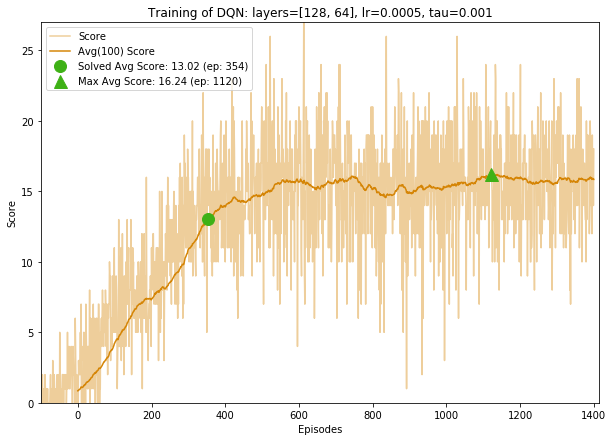

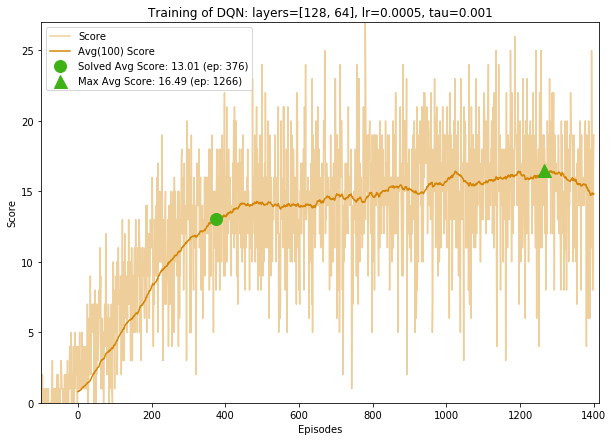

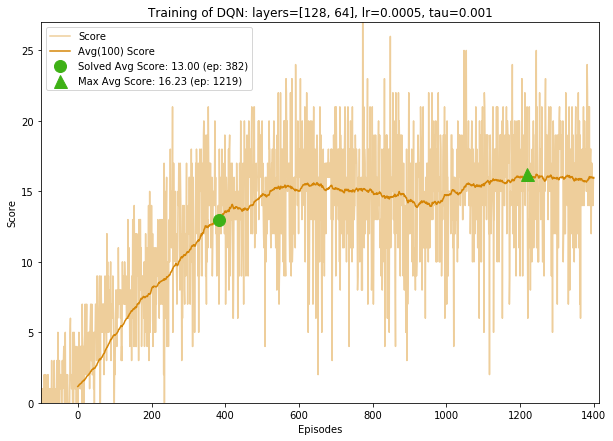

In [7]:
params={"use_ddqn":False, "use_dueling":False, "hidden_layers":[128,64], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.2 Training of DQNs, hidden layers = [64,32]

1) Training of DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 377 episodes!	Average Score: 13.01
Best score: 16.59 (global: 17.45)
2) Training of DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 393 episodes!	Average Score: 13.01
Best score: 16.8 (global: 17.45)8
3) Training of DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 386 episodes!	Average Score: 13.01
Best score: 17.11 (global: 17.45)

Summary:
Solved episode (mean): 385
Max score (mean/absolute): 16.83/17.11


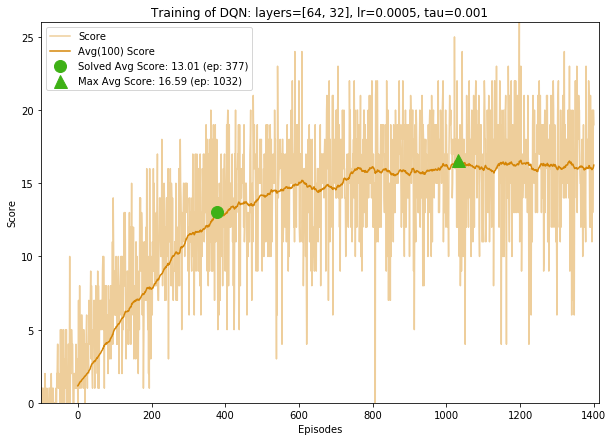

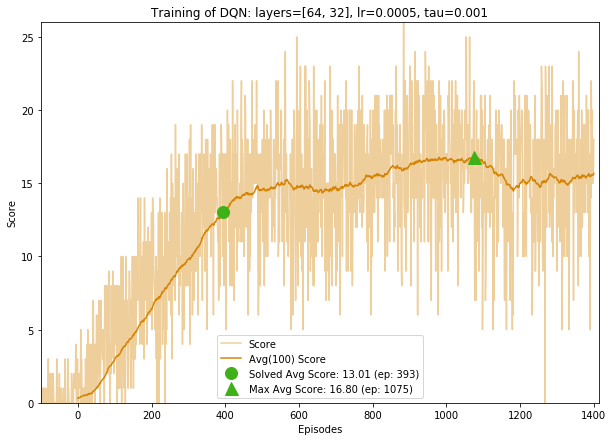

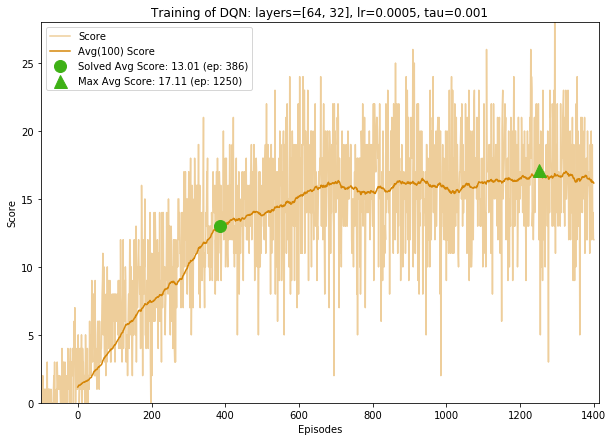

In [11]:
params={"use_ddqn":False, "use_dueling":False, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.3 Training of DQNs, hidden layers = [32,16]

1) Training of DQN: layers=[32, 16], lr=0.0005, tau=0.001
Environment solved in 442 episodes!	Average Score: 13.04
Best score: 17.29 (global: 17.45)
2) Training of DQN: layers=[32, 16], lr=0.0005, tau=0.001
Environment solved in 379 episodes!	Average Score: 13.03
Best score: 17.05 (global: 17.45)
3) Training of DQN: layers=[32, 16], lr=0.0005, tau=0.001
Environment solved in 417 episodes!	Average Score: 13.08
Best score: 17.23 (global: 17.45)

Summary:
Solved episode (mean): 413
Max score (mean/absolute): 17.19/17.29


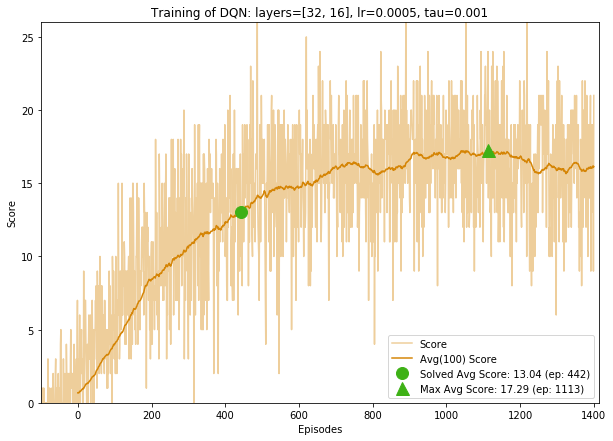

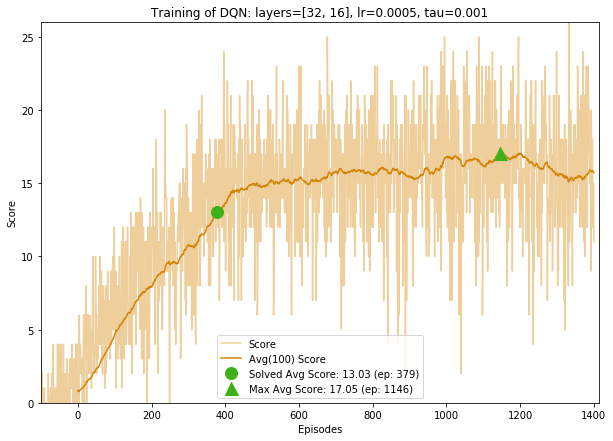

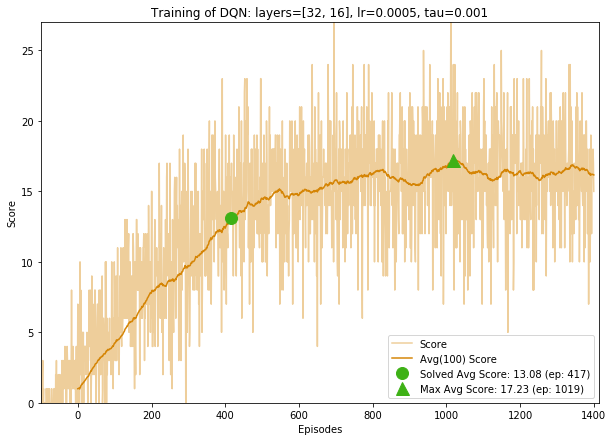

In [12]:
params={"use_ddqn":False, "use_dueling":False, "hidden_layers":[32,16], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.4 Training of  Double DQNs, hidden layers = [128, 64]

1) Training of Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 375 episodes!	Average Score: 13.02
Best score: 17.14 (global: 17.14)
2) Training of Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 407 episodes!	Average Score: 13.14
Best score: 17.45 (global: 17.45)
3) Training of Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 387 episodes!	Average Score: 13.04
Best score: 16.72 (global: 17.45)

Summary:
Solved episode (mean): 390
Max score (mean/absolute): 17.10/17.45


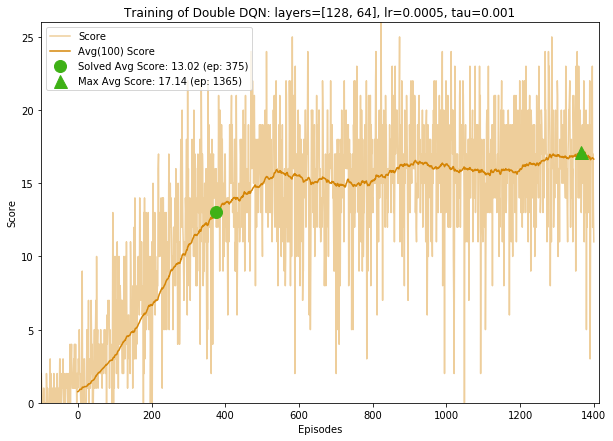

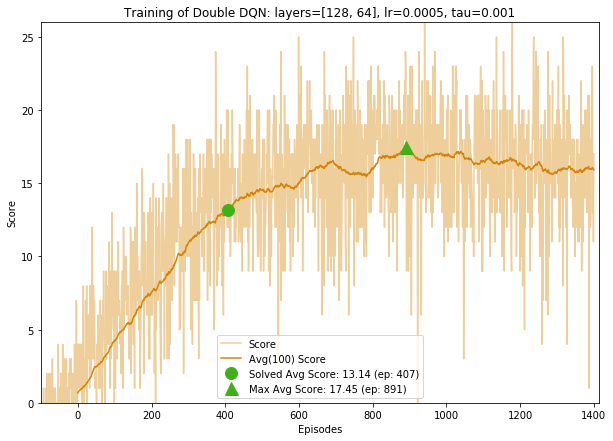

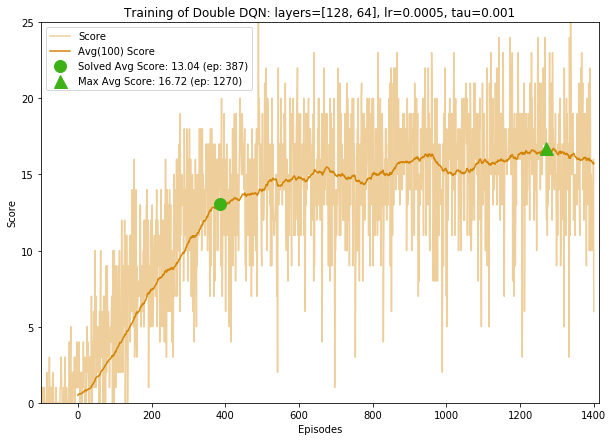

In [12]:
params={"use_ddqn":True, "use_dueling":False, "hidden_layers":[128,64], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.5 Training of  Double DQNs, hidden layers = [64,32]

Device: cpu
1) Training of Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 391 episodes!	Average Score: 13.00
Best score: 16.52 (global: 17.45)
2) Training of Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 434 episodes!	Average Score: 13.01
Best score: 16.93 (global: 17.45)
3) Training of Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 394 episodes!	Average Score: 13.01
Best score: 17.4 (global: 17.45)4

Summary:
Solved episode (mean): 406
Max score (mean/absolute): 16.95/17.40


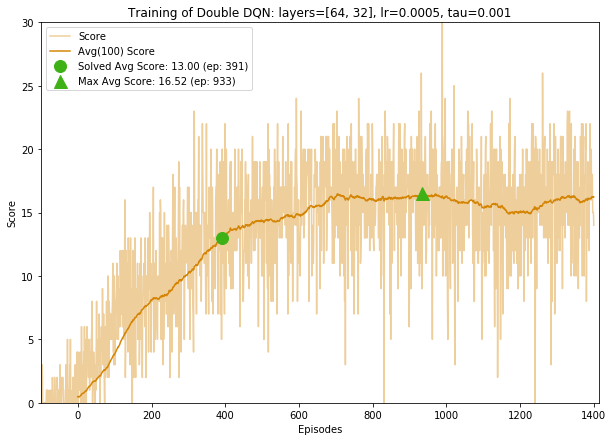

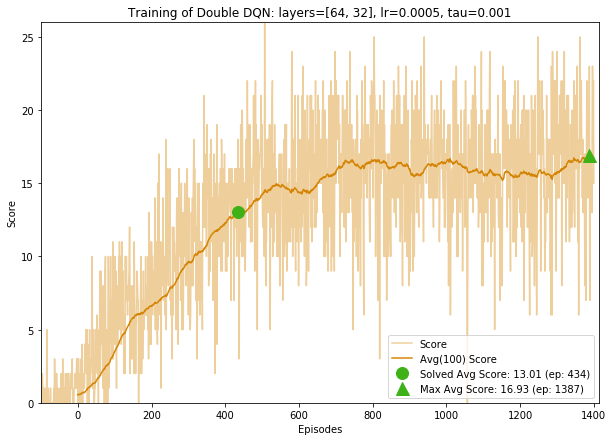

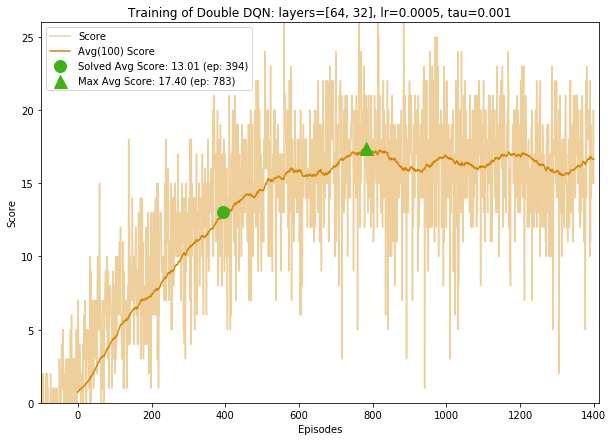

In [14]:
params={"use_ddqn":True, "use_dueling":False, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.6 Training of Dueling DQNs, hidden layers = [128, 64]

1) Training of Dueling DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 443 episodes!	Average Score: 13.00
Best score: 16.78 (global: 17.45)
2) Training of Dueling DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 440 episodes!	Average Score: 13.02
Best score: 16.29 (global: 17.45)
3) Training of Dueling DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 405 episodes!	Average Score: 13.01
Best score: 16.12 (global: 17.45)

Summary:
Solved episode (mean): 429
Max score (mean/absolute): 16.40/16.78


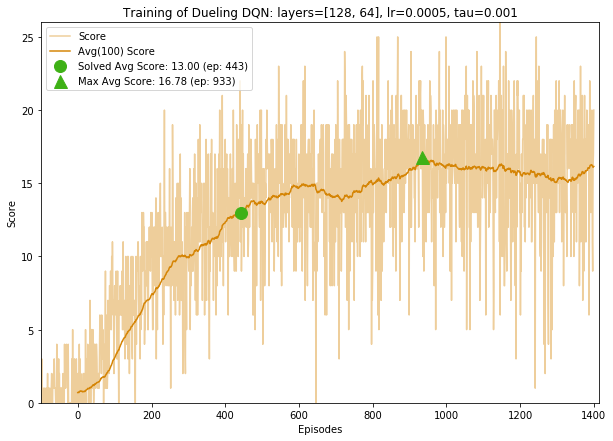

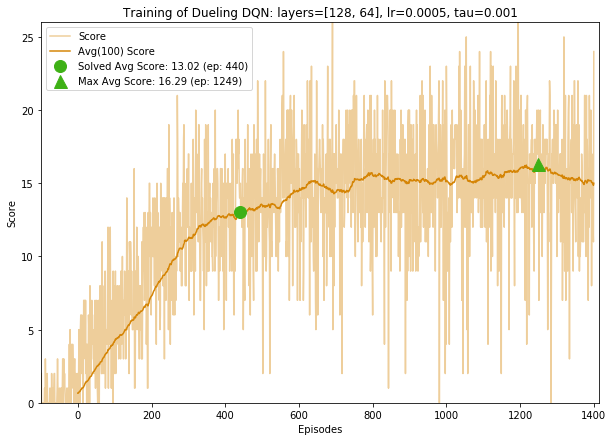

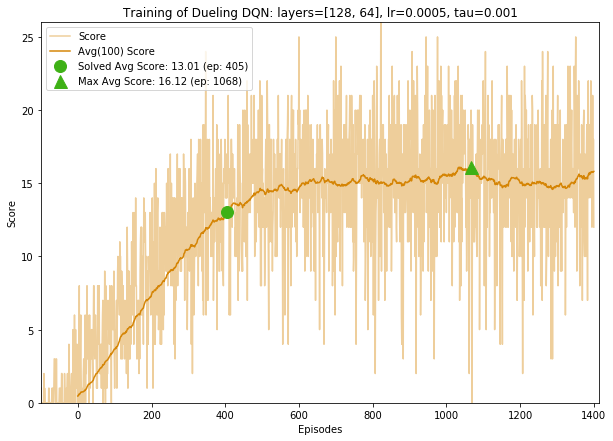

In [7]:
params={"use_ddqn":False, "use_dueling":True, "hidden_layers":[128,64], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.7 Training of Dueling DQNs, hidden layers = [64,32]

1) Training of Dueling DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 354 episodes!	Average Score: 13.00
Best score: 16.73 (global: 17.45)
2) Training of Dueling DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 383 episodes!	Average Score: 13.03
Best score: 17.22 (global: 17.45)
3) Training of Dueling DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 412 episodes!	Average Score: 13.00
Best score: 17.12 (global: 17.45)

Summary:
Solved episode (mean): 383
Max score (mean/absolute): 17.02/17.22


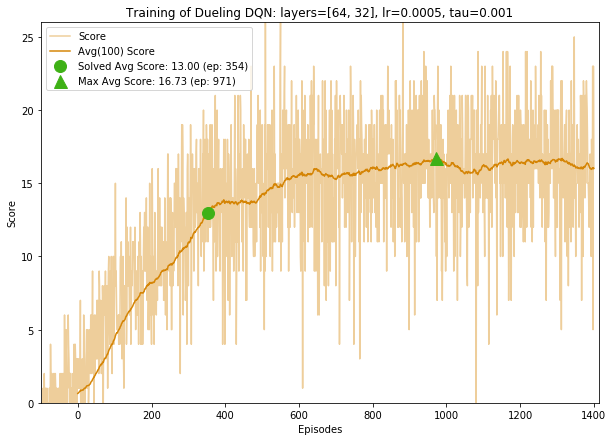

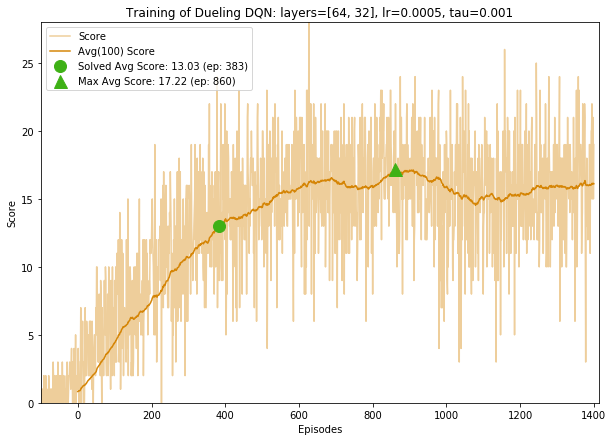

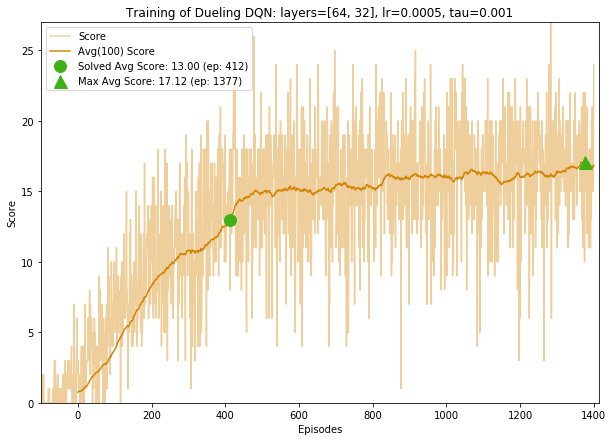

In [8]:
params={"use_ddqn":False, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.8 Training of Dueling Double DQNs, hidden layers = [128, 64]

1) Training of Dueling Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 429 episodes!	Average Score: 13.00
Best score: 17.03 (global: 17.45)
2) Training of Dueling Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 384 episodes!	Average Score: 13.07
Best score: 16.58 (global: 17.45)
3) Training of Dueling Double DQN: layers=[128, 64], lr=0.0005, tau=0.001
Environment solved in 379 episodes!	Average Score: 13.05
Best score: 16.95 (global: 17.45)

Summary:
Solved episode (mean): 397
Max score (mean/absolute): 16.85/17.03


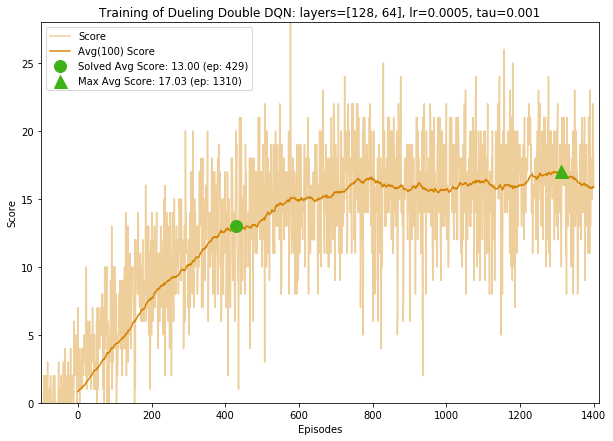

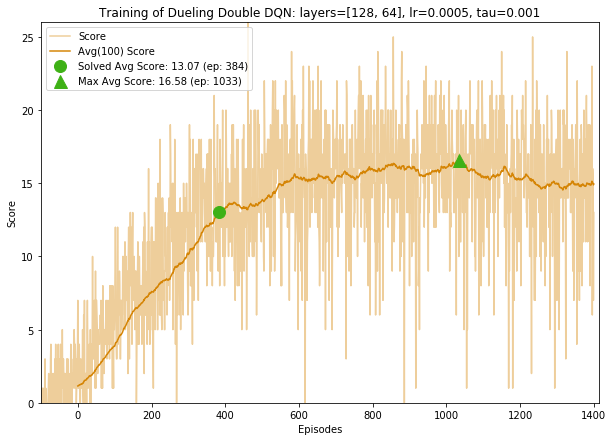

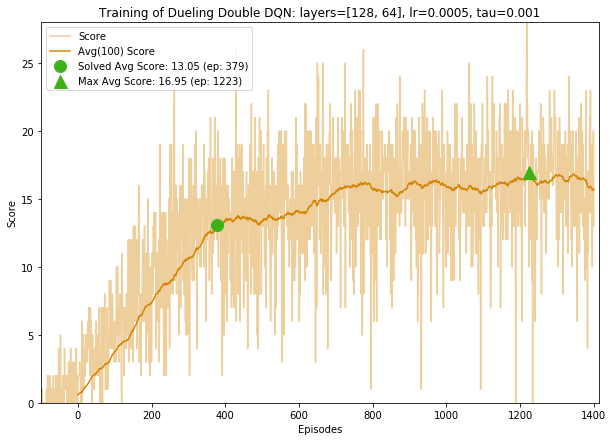

In [9]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[128,64], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.9 Training of Dueling Double DQNs, hidden layers = [64,32]

1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 351 episodes!	Average Score: 13.00
Best score: 16.79 (global: 17.45)
2) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 390 episodes!	Average Score: 13.06
Best score: 16.94 (global: 17.45)
3) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 360 episodes!	Average Score: 13.09
Best score: 16.82 (global: 17.45)

Summary:
Solved episode (mean): 367
Max score (mean/absolute): 16.85/16.94


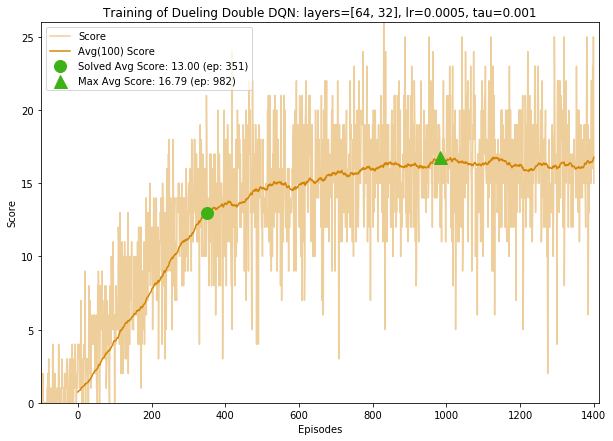

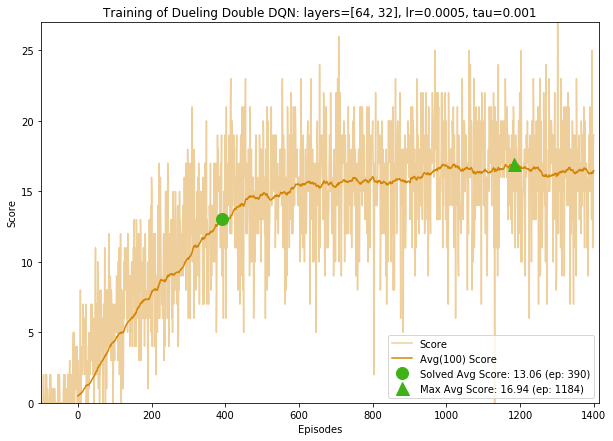

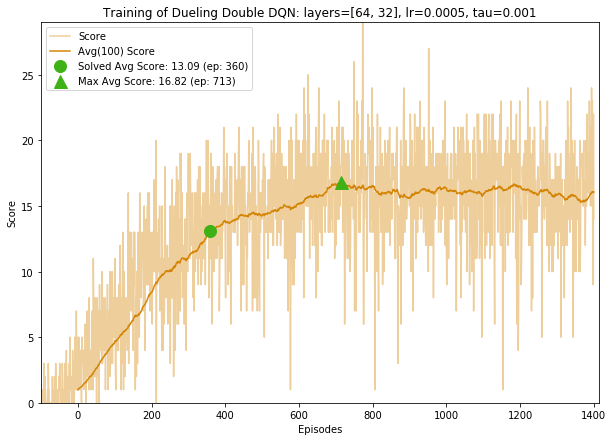

In [10]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
train_some_agents(3,**params)

### 4.10 Effect of 'tau' on the training of Dueling Double DQN



--- Training with tau = 0.01 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.01
Environment solved in 455 episodes!	Average Score: 13.05
Best score: 16.42 (global: 17.56)

Summary:
Solved episode (mean): 455
Max score (mean/absolute): 16.42/16.42

--- Training with tau = 0.005 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.005
Environment solved in 497 episodes!	Average Score: 13.07
Best score: 16.49 (global: 17.56)

Summary:
Solved episode (mean): 497
Max score (mean/absolute): 16.49/16.49

--- Training with tau = 0.002 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.002
Environment solved in 420 episodes!	Average Score: 13.00
Best score: 17.19 (global: 17.56)

Summary:
Solved episode (mean): 420
Max score (mean/absolute): 17.19/17.19

--- Training with tau = 0.001 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 384 episodes!	Average Score: 13.02
Best score: 

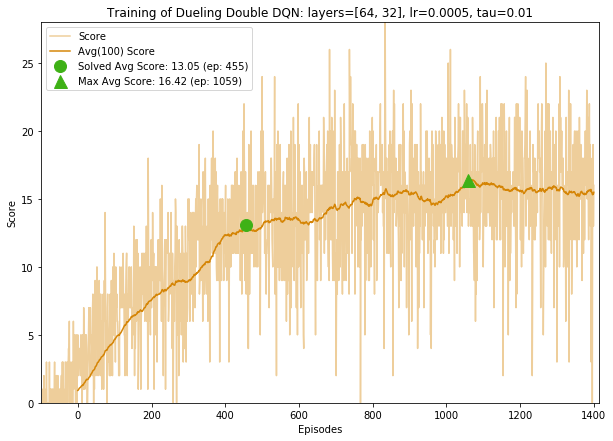

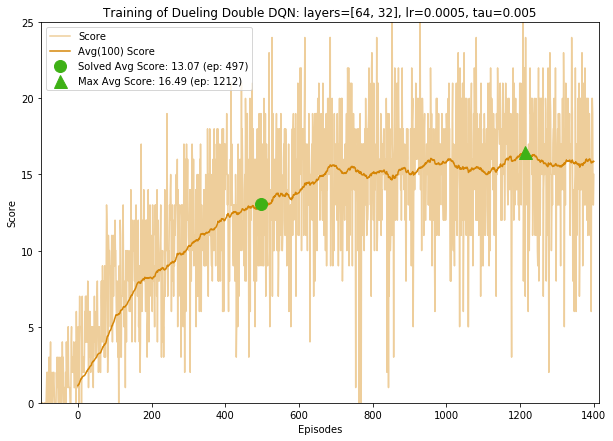

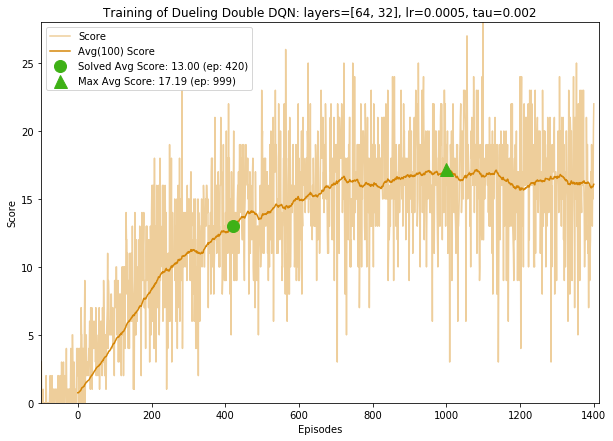

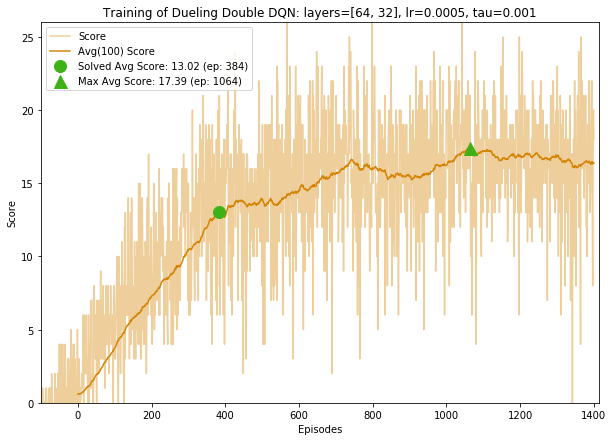

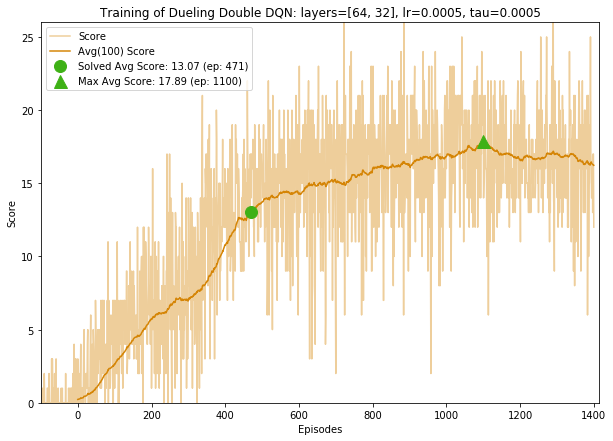

In [8]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, 
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
for tau in [1e-2,5e-3,2e-3,1e-3,5e-4]:
    params["tau"] = tau
    print(f"\n--- Training with tau = {tau} ---")
    train_some_agents(1,**params)

### 4.11 Effect of 'eps_end' on the training of Dueling Double DQN



--- Training with eps_end = 0.1 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 361 episodes!	Average Score: 13.03
Best score: 14.78 (global: 17.89)

Summary:
Solved episode (mean): 361
Max score (mean/absolute): 14.78/14.78

--- Training with eps_end = 0.05 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 412 episodes!	Average Score: 13.08
Best score: 16.44 (global: 17.89)

Summary:
Solved episode (mean): 412
Max score (mean/absolute): 16.44/16.44

--- Training with eps_end = 0.01 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 413 episodes!	Average Score: 13.00
Best score: 16.74 (global: 17.89)

Summary:
Solved episode (mean): 413
Max score (mean/absolute): 16.74/16.74

--- Training with eps_end = 0.005 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 359 episodes!	Average Score: 13.0

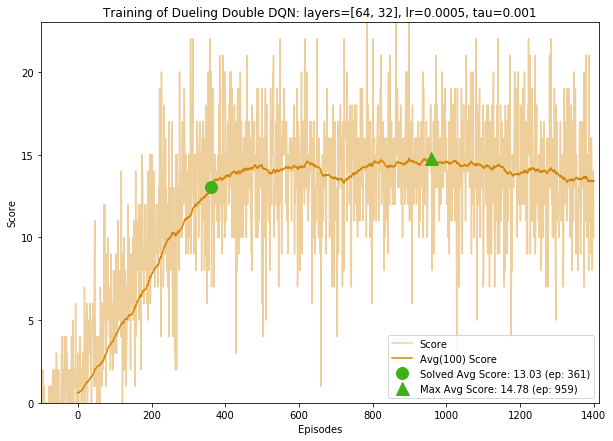

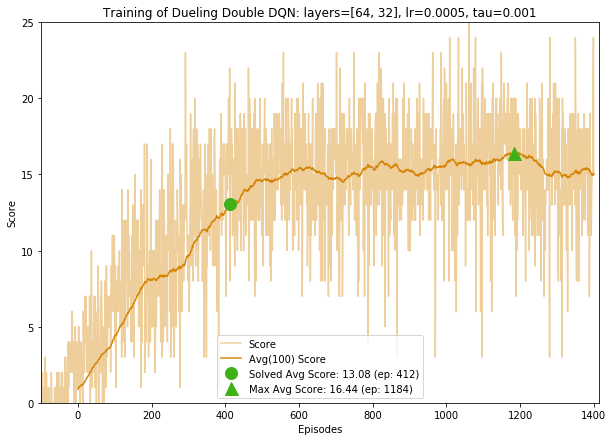

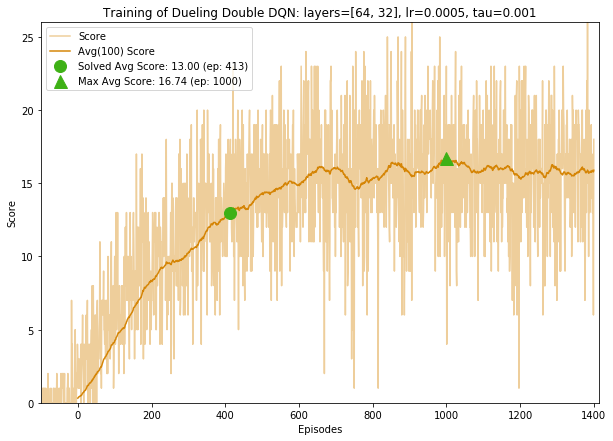

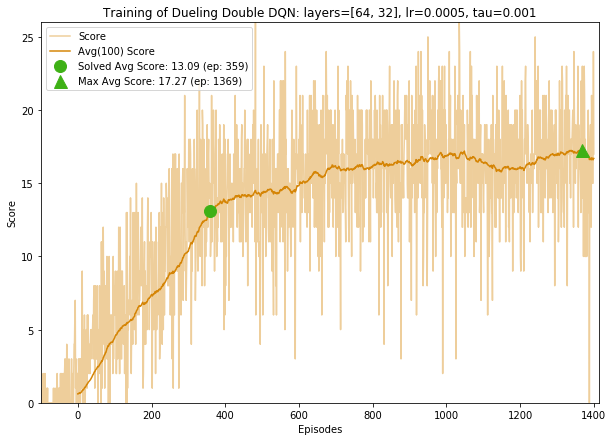

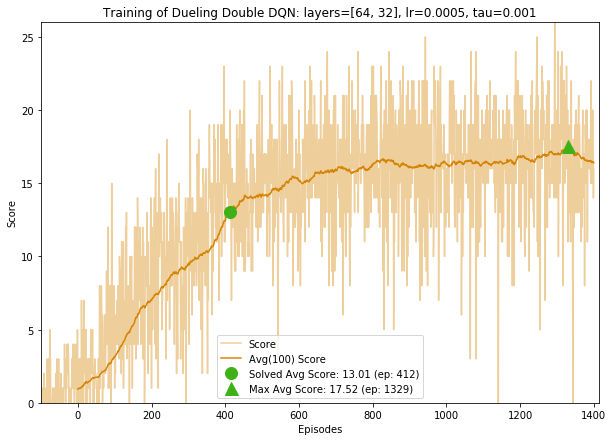

In [11]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_decay":0.995}
for eps_end in [0.1, 0.05, 0.01, 0.005, 0.0001]:
    params["eps_end"] = eps_end
    print(f"\n--- Training with eps_end = {eps_end} ---")
    train_some_agents(1,**params)

### 4.12 Effect of 'eps_decay' on the training of Dueling Double DQN



--- Training with eps_decay = 0.99 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 288 episodes!	Average Score: 13.07
Best score: 17.59 (global: 17.89)

Summary:
Solved episode (mean): 288
Max score (mean/absolute): 17.59/17.59

--- Training with eps_decay = 0.9925 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 321 episodes!	Average Score: 13.04
Best score: 17.11 (global: 17.89)

Summary:
Solved episode (mean): 321
Max score (mean/absolute): 17.11/17.11

--- Training with eps_decay = 0.995 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 390 episodes!	Average Score: 13.05
Best score: 17.21 (global: 17.89)

Summary:
Solved episode (mean): 390
Max score (mean/absolute): 17.21/17.21

--- Training with eps_decay = 0.9975 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 670 episodes!	Averag

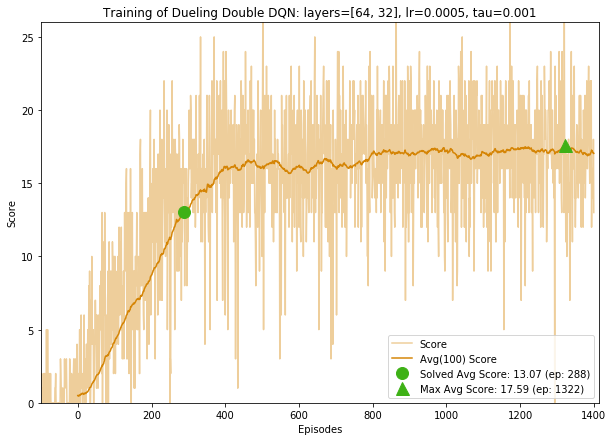

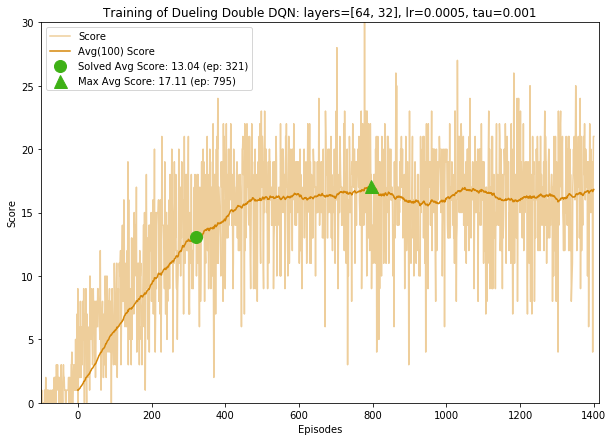

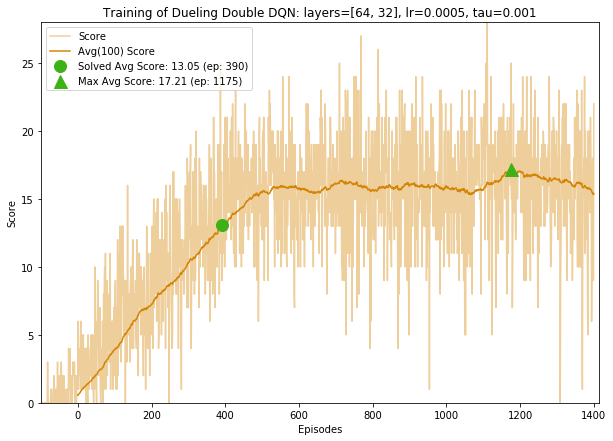

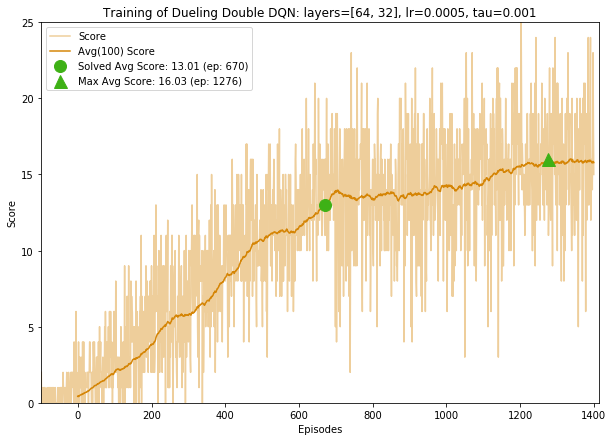

In [15]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01}
for eps_decay in [0.99, 0.9925, 0.995, 0.9975]:
    params["eps_decay"] = eps_decay
    print(f"\n--- Training with eps_decay = {eps_decay} ---")
    train_some_agents(1,**params)

### 4.13 Effect of 'gamma' on the training of Dueling Double DQN



--- Training with gamma = 1 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 327 episodes!	Average Score: 13.15
Best score: 17.08 (global: 17.89)

Summary:
Solved episode (mean): 327
Max score (mean/absolute): 17.08/17.08

--- Training with gamma = 0.999 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 315 episodes!	Average Score: 13.00
Best score: 17.41 (global: 17.89)

Summary:
Solved episode (mean): 315
Max score (mean/absolute): 17.41/17.41

--- Training with gamma = 0.995 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 337 episodes!	Average Score: 13.03
Best score: 17.26 (global: 17.89)

Summary:
Solved episode (mean): 337
Max score (mean/absolute): 17.26/17.26

--- Training with gamma = 0.99 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 302 episodes!	Average Score: 13.07
Best sc

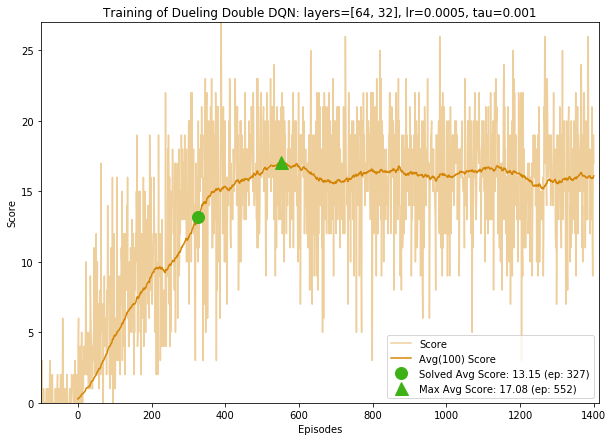

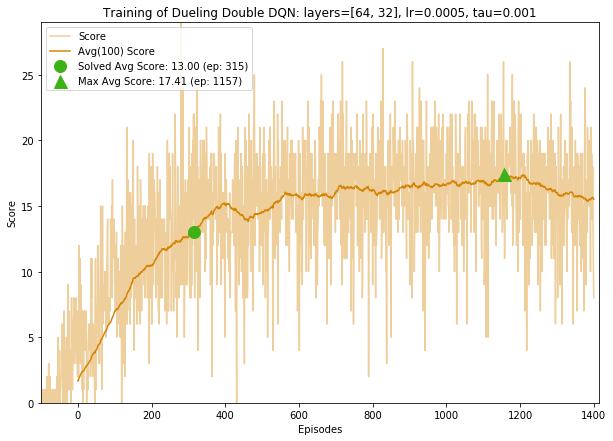

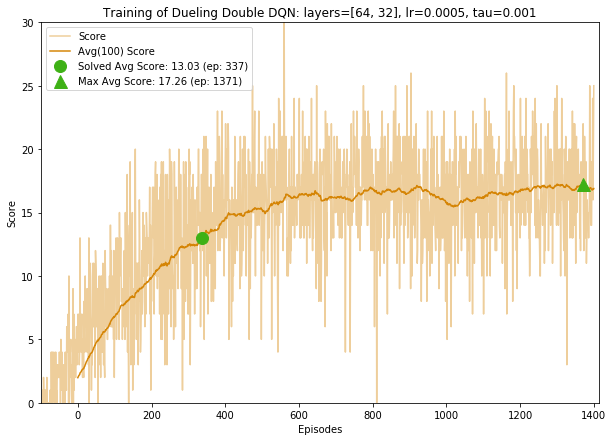

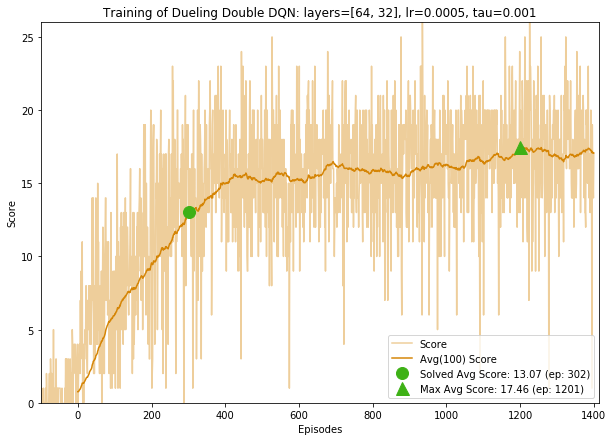

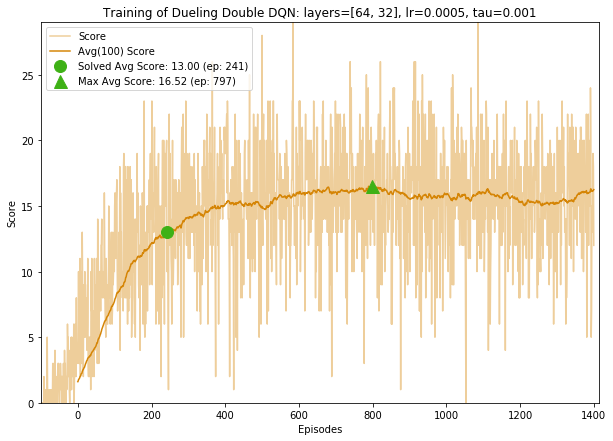

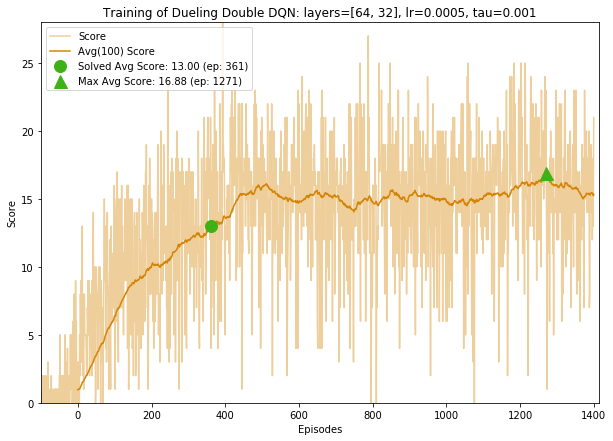

In [20]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3, 
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.99}
for gamma in [1, 0.999, 0.995, 0.99, 0.95, 0.9]:
    params["gamma"] = gamma
    print(f"\n--- Training with gamma = {gamma} ---")
    train_some_agents(1,**params)

### 4.14 Effect of 'lr' on the training of Dueling Double DQN


--- Training with lr = 0.01 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.01, tau=0.001
Best score: 8.81 (global: 17.45)

Summary:
Solved episode (mean): nan
Max score (mean/absolute): 8.81/8.81
--- Training with lr = 0.005 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.005, tau=0.001


/home/gx/anaconda3/envs/tf17/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gx/anaconda3/envs/tf17/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Environment solved in 716 episodes!	Average Score: 13.01
Best score: 14.82 (global: 17.45)

Summary:
Solved episode (mean): 716
Max score (mean/absolute): 14.82/14.82
--- Training with lr = 0.001 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.001, tau=0.001
Environment solved in 434 episodes!	Average Score: 13.00
Best score: 17.25 (global: 17.45)

Summary:
Solved episode (mean): 434
Max score (mean/absolute): 17.25/17.25
--- Training with lr = 0.0005 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 424 episodes!	Average Score: 13.04
Best score: 16.99 (global: 17.45)

Summary:
Solved episode (mean): 424
Max score (mean/absolute): 16.99/16.99
--- Training with lr = 0.0001 ---
1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0001, tau=0.001
Environment solved in 428 episodes!	Average Score: 13.00
Best score: 17.56 (global: 17.56)

Summary:
Solved episode (mean): 428
Max score (mean/absolute): 17.56/17.56


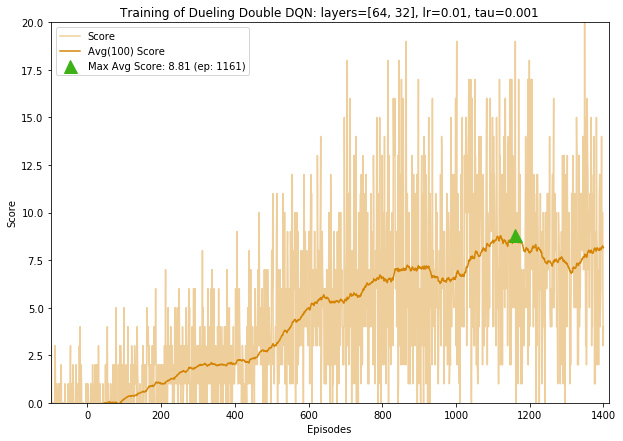

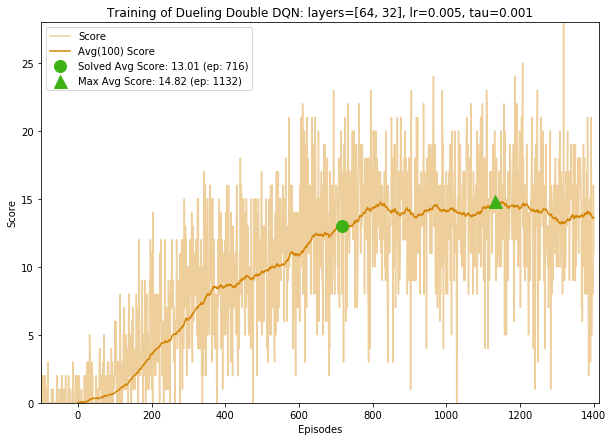

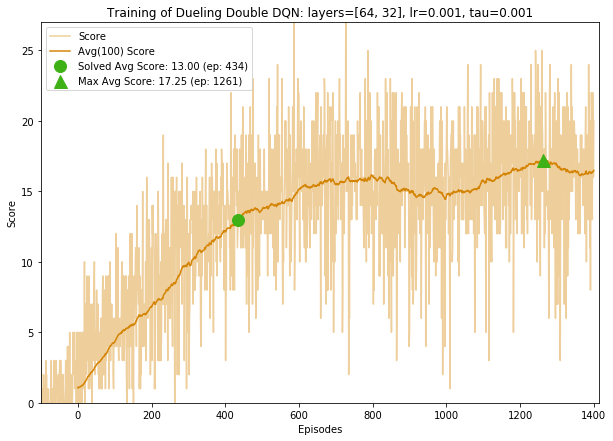

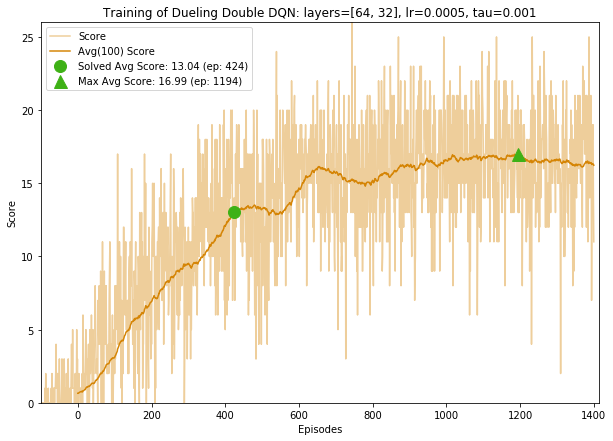

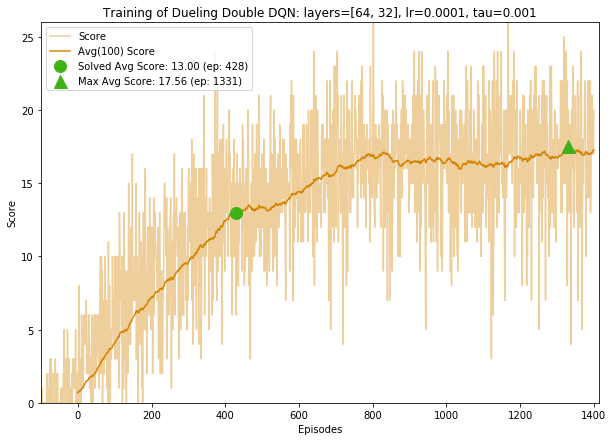

In [7]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "tau":1e-3,
        "eps_start":1.0, "eps_end":0.01, "eps_decay":0.995}
for lr in [1e-2,5e-3,1e-3,5e-4,1e-4]:
    params["lr"] = lr
    print(f"--- Training with lr = {lr} ---")
    train_some_agents(1,**params)

## 5. Best hyperparameters ?
From the tests above, for each hyperparameter, we keep the value which gave the best solved score, and then, we train a few agents with these values. Do we break the record ?
<br><br>Indeed ! We have an agent that **solved the environment in 233 episodes** !

1) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 280 episodes!	Average Score: 13.02
Best score: 17.31 (global: 17.89)
2) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 233 episodes!	Average Score: 13.03
Best score: 17.31 (global: 17.89)
3) Training of Dueling Double DQN: layers=[64, 32], lr=0.0005, tau=0.001
Environment solved in 299 episodes!	Average Score: 13.08
Best score: 18.11 (global: 18.11)

Summary:
Solved episode (mean): 271
Max score (mean/absolute): 17.58/18.11


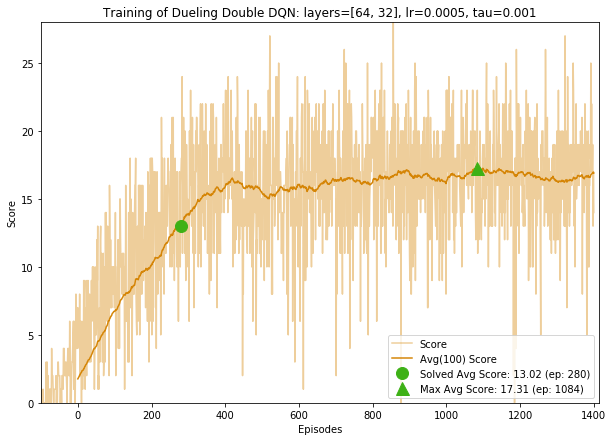

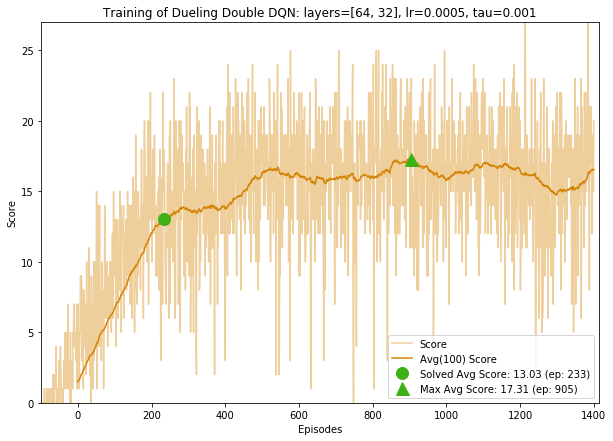

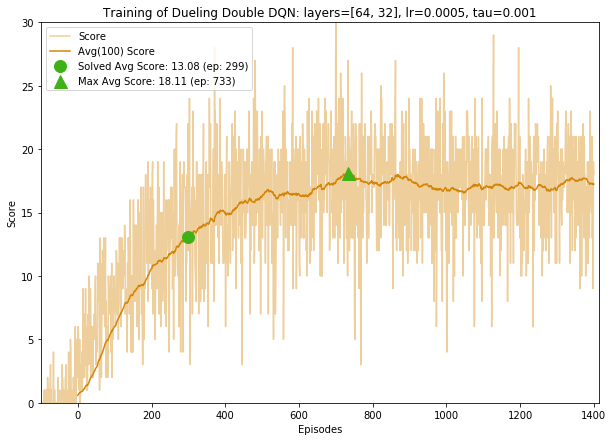

In [22]:
params={"use_ddqn":True, "use_dueling":True, "hidden_layers":[64,32], 
        "n_episodes":1500, "lr":5e-4, "tau":1e-3, "gamma":0.95,
        "eps_start":1.0, "eps_end":0.005, "eps_decay":0.99}
train_some_agents(3,**params)

## 6. Watch a Smart Agent!

In the next code cell, we load the trained weights from file to watch a smart agent!

In [9]:
# load the weights from file
checkpoint=torch.load('checkpoint.pth')
print(f"Agent: {'Dueling ' if checkpoint['use_dueling'] else ''}{'Double ' if checkpoint['use_ddqn'] else ''}DQN, layers={checkpoint['hidden_layers']}, best training score = {checkpoint['score']}")

for k in ['eps_start','eps_end','eps_decay','lr','tau']:
    print(k,checkpoint[k])
agent = Agent(use_dueling=checkpoint['use_dueling'],state_size=state_size, action_size=action_size, hidden_layers=checkpoint["hidden_layers"])
agent.qnetwork_local.load_state_dict(checkpoint["state_dict"])
print(agent.qnetwork_local)

for i in range(3):
    score=0
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    
    print(f"Episode {i+1} score: {score}")       


Agent: Dueling Double DQN, layers=[64, 32], best training score = 18.11
eps_start 1.0
eps_end 0.005
eps_decay 0.99
lr 0.0005
tau 0.001
QNetwork(
  (fcs): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
  )
  (fc_val1): Linear(in_features=64, out_features=32, bias=True)
  (fc_val2): Linear(in_features=32, out_features=1, bias=True)
  (fc_adv1): Linear(in_features=64, out_features=32, bias=True)
  (fc_adv2): Linear(in_features=32, out_features=4, bias=True)
)
Episode 1 score: 18.0
Episode 2 score: 15.0
Episode 3 score: 8.0


In [ ]:
env.close()